# LIVENES DETECTION MODEL - C242-LT02
#### - m296b4kx0921 – Cheisya Alya Natasya – UPN “Veteran” Jatim 
#### - m312b4ky3609 – Rafly Amanta Haryanto – Universitas Sebelas Maret
Reference: https://www.youtube.com/watch?v=N_W4EYtsa10&t=7511s


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [5]:
%pip install labelme tensorflow opencv-python matplotlib albumentations cv2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


### 1.2 Annotate Images with LabelMe

In [ ]:
import os
import cv2

In [ ]:
!labelme

In [7]:
!pip install cvzone

^C


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for opencv-python: filename=opencv_python-4.10.0.84-cp38-cp38-win_amd64.whl size=37996891 sha256=956f115fab97e38fdd86fe3fe3819a93510d18aa517c1b02c207abbab220bd18
  Stored in directory: C:\Users\rafly\AppData\Local\pip\Cache\wheels\4d\37\60\c3e69706c0a285bdaaad437e28d3cdbb3664a9211ae78c7a20
Successfully built opencv-python
  Running setup.py install for cvzone: started
    Running setup.py install for cvzone: finished with status 'done'


In [44]:
!pip list

Package       Version  
------------- ---------
cvzone        1.6.1    
numpy         1.24.4   
opencv-python 4.10.0.84
pip           19.2.3   
setuptools    41.2.0   


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [3]:
gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)


### 2.3 Load Image into TF Data Pipeline

In [11]:
jpg_images = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/all/*.jpg', shuffle=False)
png_images = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/all/*.png', shuffle=False)

images = jpg_images.concatenate(png_images)

In [12]:
images.as_numpy_iterator().next()

b'G:\\My Drive\\LivenessDetectionmMobilenet\\dataset\\all\\-0bd9d8c90c1199961a5970e392c7309e_jpg.rf.5f3f585435f2a3ecd3c27c1fc80d076d.jpg'

In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

array([[[140, 150, 152],
        [140, 150, 152],
        [140, 150, 152],
        ...,
        [154, 165, 149],
        [156, 167, 153],
        [157, 168, 154]],

       [[140, 150, 152],
        [140, 150, 152],
        [140, 150, 152],
        ...,
        [152, 165, 148],
        [154, 166, 152],
        [155, 167, 153]],

       [[140, 150, 152],
        [140, 150, 152],
        [140, 150, 152],
        ...,
        [148, 165, 146],
        [152, 166, 149],
        [153, 167, 150]],

       ...,

       [[ 99,  86,  51],
        [ 99,  86,  51],
        [ 99,  86,  51],
        ...,
        [142, 148, 162],
        [142, 148, 162],
        [142, 148, 162]],

       [[ 98,  85,  50],
        [ 98,  85,  50],
        [ 98,  85,  50],
        ...,
        [142, 148, 162],
        [141, 147, 161],
        [141, 147, 161]],

       [[ 97,  84,  49],
        [ 98,  85,  50],
        [ 98,  85,  50],
        ...,
        [141, 147, 161],
        [141, 147, 161],
        [141, 147, 161]]], dtype=uint8)
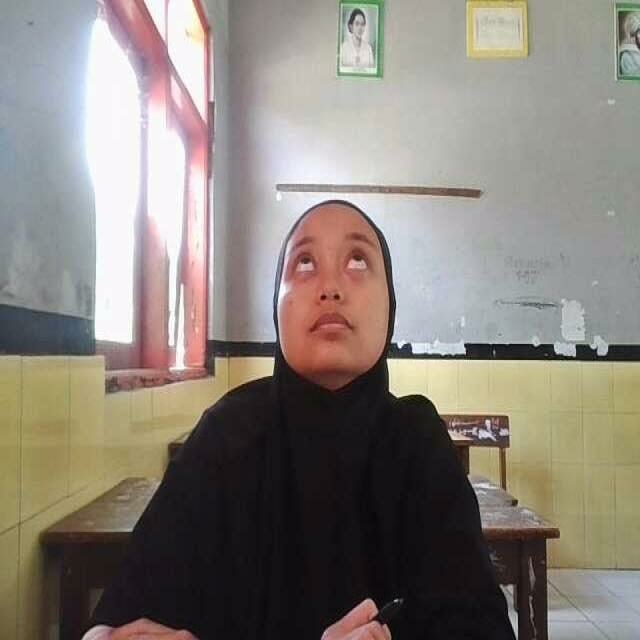

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

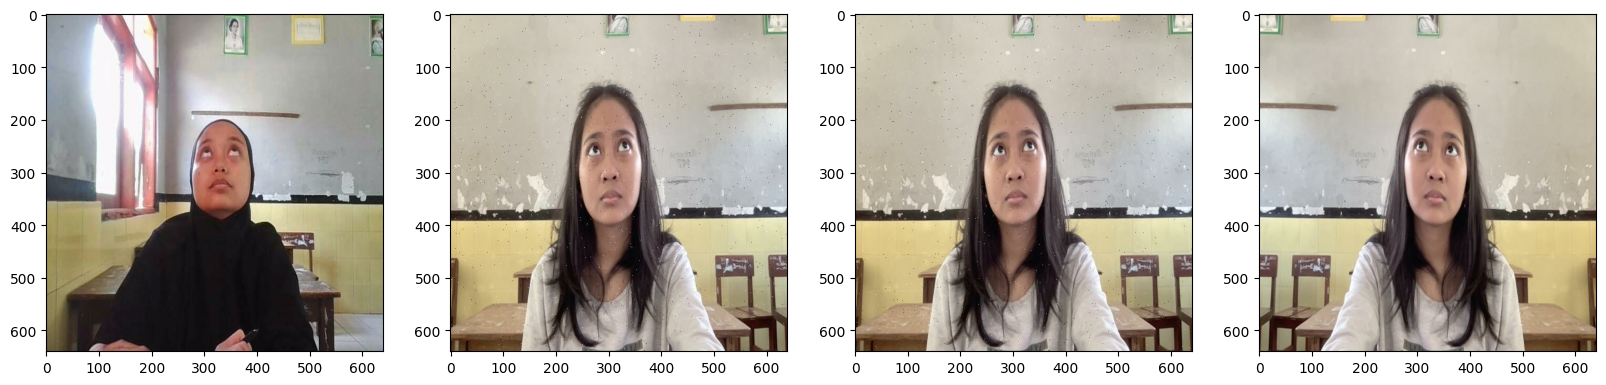

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

### 3.1 SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
def split_images(source_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Splits images in a source directory into train, validation, and test sets.

    Args:
        source_dir: Path to the source directory containing images.
        train_dir: Path to the directory for training images.
        val_dir: Path to the directory for validation images.
        test_dir: Path to the directory for test images.
        train_ratio: Proportion of images to allocate to the training set.
        val_ratio: Proportion of images to allocate to the validation set.
        test_ratio: Proportion of images to allocate to the test set.
    """
    # Create target directories if they don't exist
    for dir in [train_dir, val_dir, test_dir]:
        if not os.path.exists(dir):
            os.makedirs(dir)

    # Get a list of all image files in the source directory
    image_files = os.listdir(source_dir)

    # Shuffle the list of image files randomly
    random.shuffle(image_files)

    # Calculate the number of images for each set
    total_images = len(image_files)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    test_size = total_images - train_size - val_size

    # Split the image files into train, validation, and test sets
    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size+val_size]
    test_files = image_files[train_size+val_size:]

    # Copy images to their respective directories
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))
    for file in val_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(val_dir, file))
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))


In [ ]:
source_up_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Up'
source_down_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Down'
source_right_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Right'
source_left_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Left'

train_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/images'
val_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/val/images'
test_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/test/images'

In [ ]:
split_images(source_up_dir, train_dir, val_dir, test_dir)

In [ ]:
split_images(source_down_dir, train_dir, val_dir, test_dir)

In [ ]:
split_images(source_right_dir, train_dir, val_dir, test_dir)

In [ ]:
split_images(source_left_dir, train_dir, val_dir, test_dir)

In [ ]:
def count_images_in_source_dirs(source_dirs):
    total_images = 0
    for source_dir in source_dirs:
        # Get the number of image files in each source directory
        image_count = len([file for file in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, file))])
        print(f"Number of images in {source_dir}: {image_count}")
        total_images += image_count
    print(f"Total number of images across all source directories: {total_images}")
    return total_images

# Example usage
source_dirs = [
    '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Up',
    '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Down',
    '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Left',
    '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Right'
]

total_images_in_source = count_images_in_source_dirs(source_dirs)


Number of images in /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Up: 104
Number of images in /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Down: 108
Number of images in /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Left: 100
Number of images in /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Right: 202
Total number of images across all source directories: 514


In [ ]:
def count_images_in_directory(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])

train_image_count = count_images_in_directory(train_dir)
val_image_count = count_images_in_directory(val_dir)
test_image_count = count_images_in_directory(test_dir)

print(f"Training images: {train_image_count}")
print(f"Validation images: {val_image_count}")
print(f"Test images: {test_image_count}")


Training images: 358
Validation images: 76
Test images: 80


In [ ]:
# FOR DEBUGGING PURPOSES
# def delete_all_images(folder_path):
#     """Deletes all images from the specified folder.

#     Args:
#         folder_path: Path to the folder containing images to delete.
#     """
#     # Supported image extensions
#     image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')

#     # Check if the folder exists
#     if not os.path.exists(folder_path):
#         print(f"The folder '{folder_path}' does not exist.")
#         return

#     # Iterate through all files in the folder
#     for file_name in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, file_name)

#         # Check if the file has an image extension and is a file
#         if os.path.isfile(file_path) and file_name.lower().endswith(image_extensions):
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")

#     print("All images have been deleted.")

In [ ]:
# folder_path = '/path/to/your/folder'
# delete_all_images(folder_path)

### 3.2 Move the Matching Labels

In [ ]:
# Define the base folder paths in Google Drive
base_drive_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet'
source_label_path = os.path.join(base_drive_path, 'dataset', 'labels')

for folder in ['train', 'test', 'val']:
    # Define folder-specific paths
    image_folder = os.path.join(base_drive_path, 'dataset', folder, 'images')
    label_folder = os.path.join(base_drive_path, 'dataset', folder, 'labels')

    # Ensure destination label folder exists
    os.makedirs(label_folder, exist_ok=True)

    # Iterate over images in the current folder
    for file in os.listdir(image_folder):
        # Extract image base name
        image_name = os.path.splitext(file)[0]
        filename = f"{image_name}.json"

        # Paths for source and destination
        existing_filepath = os.path.join(source_label_path, filename)
        new_filepath = os.path.join(label_folder, filename)

        # Check if label file exists
        if os.path.exists(existing_filepath):
            try:
                shutil.copy(existing_filepath, new_filepath)
                print(f"Copied {filename} to {new_filepath}")
            except Exception as e:
                print(f"Error copying {filename}: {e}")
        else:
            print(f"Label file not found for image: {file}")


Copied 43fd26e1b508c9c5_jpg.rf.d7c9e41e4eb33267c911022e705d0431.json to /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels/43fd26e1b508c9c5_jpg.rf.d7c9e41e4eb33267c911022e705d0431.json
Copied Terang_Frame_1866_png.rf.b3a7f4760c953e283406f8c4fe79d7ea.json to /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels/Terang_Frame_1866_png.rf.b3a7f4760c953e283406f8c4fe79d7ea.json
Copied 1e12d526df960ed2091aeb9f99a80de_jpg.rf.ee333b82d653f78263823d1c0c2a6ed8.json to /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels/1e12d526df960ed2091aeb9f99a80de_jpg.rf.ee333b82d653f78263823d1c0c2a6ed8.json
Copied AtasBudeGelap_56_jpg.rf.8cb6b2b7d287ea3234339eeaeed7cd7c.json to /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels/AtasBudeGelap_56_jpg.rf.8cb6b2b7d287ea3234339eeaeed7cd7c.json
Copied ce07cc80f1570_jpg.rf.eb1574dff1f73e6effc7c79cb45b0956.json to /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels/ce0

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [ ]:
!pip install albumentations
import albumentations as alb

In [ ]:
augmentor = alb.Compose(
    [
        alb.RandomBrightnessContrast(p=0.3),  # Adjust brightness and contrast
        alb.RandomGamma(p=0.3),               # Random gamma correction
        alb.RGBShift(p=0.3),                  # Random RGB channel shifts
        alb.ShiftScaleRotate(                # Subtle shifts, scaling, and rotations
            shift_limit=0.05,
            scale_limit=0.05,
            rotate_limit=10,  # Reduced rotation limit for safety
            p=0.4
        ),
        alb.MotionBlur(blur_limit=3, p=0.2),  # Simulate subtle camera movement
        alb.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Slight blurring
        alb.ISONoise(p=0.2),                  # Mimic realistic noise
        alb.HueSaturationValue(              # Subtle color adjustments
            hue_shift_limit=8,
            sat_shift_limit=15,
            val_shift_limit=8,
            p=0.3
        ),
        alb.Perspective(scale=(0.02, 0.05), p=0.2),  # Very minor perspective distortion
        alb.CLAHE(clip_limit=2, p=0.2),      # Contrast enhancement for clarity
    ]
)


### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [ ]:
# Adjust the path to point to your Drive folder
img_path = os.path.join('/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/images', 'Copy of Screenshot 2024-10-01 123239.png')

img = cv2.imread(img_path)
assert img is not None, "Image failed to load. Check the file path."


In [ ]:
# Adjust the path to point to your Drive folder
json_path = os.path.join('/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels', 'Copy of Screenshot 2024-10-01 123239.json')

with open(json_path, 'r') as f:
    label = json.load(f)


In [ ]:
label['shapes'][0]['label']

'right'

### 4.3 Apply Augmentations and View Results

In [ ]:
def augment(image, class_labels):
    # Apply augmentations to the image only
    augmented = augmentor(image=image)

    # Return the augmented image and the original class labels (unchanged)
    return augmented['image'], class_labels

# Example usage:
# Assuming class_labels contains the associated labels
augmented_image, augmented_class_labels = augment(img, class_labels)

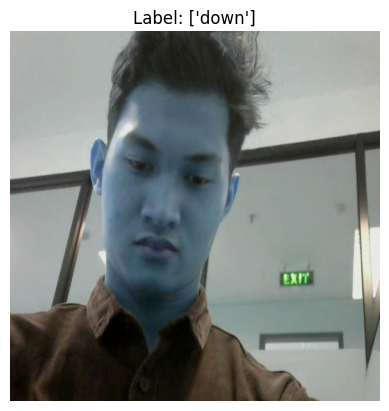

In [ ]:
plt.imshow(augmented_image)
plt.title(f"Label: {class_labels}")
plt.axis('off')
plt.show()

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [ ]:
# Define the folder path
folder_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/all'

# List of common image extensions (you can modify this as needed)
image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff']

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Count how many of them are images (i.e., have an image extension)
image_count = sum(1 for file in files if os.path.splitext(file)[1].lower() in image_extensions)

print(f'Total number of images in the folder: {image_count}')


Total number of images in the folder: 514


In [ ]:
# Define base paths in Google Drive
base_drive_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet'
dataset_path = os.path.join(base_drive_path, 'dataset')
augmented_dataset_path = os.path.join(base_drive_path, 'aug_dataset')

# Label mapping
label_mapping = {'up': 0, 'down': 1, 'right': 2, 'left': 3}

# Augment images for each partition
for partition in ['train', 'test', 'val']:
    image_folder = os.path.join(dataset_path, partition, 'images')
    label_folder = os.path.join(dataset_path, partition, 'labels')

    for image in os.listdir(image_folder):
        img_path = os.path.join(image_folder, image)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {image}. Skipping...")
            continue

        label_path = os.path.join(label_folder, f"{os.path.splitext(image)[0]}.json")
        if not os.path.exists(label_path):
            print(f"Label file not found for {image}. Skipping...")
            continue

        # Load label
        with open(label_path, 'r') as f:
            label = json.load(f)

        # Extract the class label (no need for bounding box normalization)
        class_labels = [label['shapes'][0]['label']] if 'shapes' in label and label['shapes'] else []

        if not class_labels:
            print(f"No valid labels in {label_path}. Skipping...")
            continue

        try:
            # Map labels to numerical values
            encoded_labels = [label_mapping[label] for label in class_labels]
        except KeyError as e:
            print(f"Unknown label '{e}' in {label_path}. Skipping...")
            continue

        for x in range(20):  # Generate 20 augmentations per image
            try:
                # Apply the updated augment function to the image
                augmented_image, augmented_class_labels = augment(img, encoded_labels)

                # Save augmented image
                aug_image_path = os.path.join(augmented_dataset_path, partition, 'images', f'{image.split(".")[0]}.{x}.jpg')
                os.makedirs(os.path.dirname(aug_image_path), exist_ok=True)
                cv2.imwrite(aug_image_path, augmented_image)

                # Save the corresponding annotation (class label remains unchanged)
                annotation = {
                    'image': f'{image.split(".")[0]}.{x}.jpg',
                    'class': augmented_class_labels[0] if len(augmented_class_labels) > 0 else 0
                }

                aug_label_path = os.path.join(augmented_dataset_path, partition, 'labels', f'{image.split(".")[0]}.{x}.json')
                os.makedirs(os.path.dirname(aug_label_path), exist_ok=True)
                with open(aug_label_path, 'w') as f:
                    json.dump(annotation, f)

            except Exception as e:
                print(f"Error augmenting {image}: {e}")
                continue


In [ ]:
# Define the base dataset path
dataset_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset'

# Initialize a dictionary to store file counts
file_counts = {}

# Loop through each partition
for partition in ['train', 'test', 'val']:
    # Define the image and label folder paths
    image_folder = os.path.join(dataset_path, partition, 'images')
    label_folder = os.path.join(dataset_path, partition, 'labels')

    # Count the number of files in each folder
    image_count = len([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
    label_count = len([f for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))])

    # Store the counts in the dictionary
    file_counts[partition] = {
        'images': image_count,
        'labels': label_count
    }

# Print the results
for partition, counts in file_counts.items():
    print(f"{partition.capitalize()} Partition:")
    print(f"  Total Images: {counts['images']}")
    print(f"  Total Labels: {counts['labels']}")
    print()


Train Partition:
  Total Images: 358
  Total Labels: 358

Test Partition:
  Total Images: 80
  Total Labels: 80

Val Partition:
  Total Images: 76
  Total Labels: 76



In [37]:
# Define the base dataset path
dataset_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset'

# Initialize a dictionary to store file counts
file_counts = {}

# Loop through each partition
for partition in ['train','test','val']:
    # Define the image and label folder paths
    image_folder = os.path.join(dataset_path, partition, 'images')
    label_folder = os.path.join(dataset_path, partition, 'labels')

    # Count the number of files in each folder
    image_count = len([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
    label_count = len([f for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))])

    # Store the counts in the dictionary
    file_counts[partition] = {
        'images': image_count,
        'labels': label_count
    }

# Print the results
for partition, counts in file_counts.items():
    print(f"{partition.capitalize()} Partition:")
    print(f"  Total Images: {counts['images']}")
    print(f"  Total Labels: {counts['labels']}")
    print()


Train Partition:
  Total Images: 5720
  Total Labels: 5720

Test Partition:
  Total Images: 1520
  Total Labels: 1520

Val Partition:
  Total Images: 1460
  Total Labels: 1460



### 5.2 Load Augmented Images to Tensorflow Dataset

In [7]:
# train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset/train/images/*.jpg', shuffle=False)
# train_images = train_images.map(load_image)
# train_images = train_images.map(lambda x: tf.image.resize(x, (128,128)))
# train_images = train_images.map(lambda x: x/255)

In [5]:
# LOCAL
train_images = tf.data.Dataset.list_files("D:/UNS/Kuliah/Semester 5/Bangkit/LivenessDetectionmMobilenet_CLASSONLY/aug_dataset/train/images/*.jpg", shuffle=False)
train_images = train_images.map(load_image) 
train_images = train_images.map(lambda x: tf.image.resize(x, (128,128)))
train_images = train_images.map(lambda x: x/255)


In [ ]:
# test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset/test/images/*.jpg', shuffle=False)
# test_images = test_images.map(load_image)
# test_images = test_images.map(lambda x: tf.image.resize(x, (128,128)))
# test_images = test_images.map(lambda x: x/255)

In [6]:
# LOCAL
test_images = tf.data.Dataset.list_files("D:/UNS/Kuliah/Semester 5/Bangkit/LivenessDetectionmMobilenet_CLASSONLY/aug_dataset/test/images/*.jpg", shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (128,128)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
# val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset/val/images/*.jpg', shuffle=False)
# val_images = val_images.map(load_image)
# val_images = val_images.map(lambda x: tf.image.resize(x, (128,128)))
# val_images = val_images.map(lambda x: x/255)

In [7]:
# LOCAL
val_images = tf.data.Dataset.list_files("D:/UNS/Kuliah/Semester 5/Bangkit/LivenessDetectionmMobilenet_CLASSONLY/aug_dataset/val/images/*.jpg", shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (128,128)))
val_images = val_images.map(lambda x: x/255)

In [54]:
train_images.as_numpy_iterator().next()

array([[[0.5529412 , 0.58431375, 0.59607846],
        [0.5529412 , 0.58431375, 0.59607846],
        [0.56078434, 0.5921569 , 0.6039216 ],
        ...,
        [0.50980395, 0.6313726 , 0.5058824 ],
        [0.53333336, 0.63529414, 0.5294118 ],
        [0.5647059 , 0.6313726 , 0.5568628 ]],

       [[0.5529412 , 0.58431375, 0.59607846],
        [0.5529412 , 0.58431375, 0.59607846],
        [0.56078434, 0.5921569 , 0.6039216 ],
        ...,
        [0.3764706 , 0.5372549 , 0.3647059 ],
        [0.39215687, 0.5411765 , 0.3882353 ],
        [0.39607844, 0.5294118 , 0.4       ]],

       [[0.5568628 , 0.5882353 , 0.6       ],
        [0.5568628 , 0.5882353 , 0.6       ],
        [0.5647059 , 0.59607846, 0.60784316],
        ...,
        [0.30588236, 0.38431373, 0.24705882],
        [0.4627451 , 0.54509807, 0.42352942],
        [0.5803922 , 0.65882355, 0.56078434]],

       ...,

       [[0.41568628, 0.3647059 , 0.23137255],
        [0.42352942, 0.37254903, 0.23921569],
        [0.42745098, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    class_label = np.array([label['class']], dtype=np.uint8)
    class_label = np.reshape(class_label, ())

    return class_label


### 6.2 Load Labels to Tensorflow Dataset

In [12]:
# train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset/train/labels/*.json', shuffle=False)
# train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], tf.uint8))

In [9]:
# LOCAL
train_labels = tf.data.Dataset.list_files("D:/UNS/Kuliah/Semester 5/Bangkit/LivenessDetectionmMobilenet_CLASSONLY/aug_dataset/train/labels/*.json", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], tf.uint8))

In [30]:
# test_labels = tf.data.Dataset.list_files("G:/My Drive/LivenessDetectionmMobilenet/dataset/test/labels/*.json", shuffle=False)
# test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], tf.uint8))

In [10]:
# LOCAL
test_labels = tf.data.Dataset.list_files("D:/UNS/Kuliah/Semester 5/Bangkit/LivenessDetectionmMobilenet_CLASSONLY/aug_dataset/test/labels/*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], tf.uint8))

In [31]:
# val_labels = tf.data.Dataset.list_files("G:/My Drive/LivenessDetectionmMobilenet/dataset/val/labels/*.json", shuffle=False)
# val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], tf.uint8))

In [11]:
# LOCAL
val_labels = tf.data.Dataset.list_files("D:/UNS/Kuliah/Semester 5/Bangkit/LivenessDetectionmMobilenet_CLASSONLY/aug_dataset/val/labels/*.json", shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], tf.uint8))

In [67]:
train_labels.as_numpy_iterator().next()

0

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [12]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5720, 5720, 1520, 1520, 1460, 1460)

### 7.2 Create Final Datasets (Images/Labels)

In [14]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(len(train_images))

train = train.map(
    lambda X, y: (
        tf.ensure_shape(tf.cast(X, tf.float32), (128, 128, 3)),
        tf.ensure_shape(tf.cast(y, tf.int32), ())  # Assume 1D tensor for class output
    )
)

train = train.batch(8).prefetch(tf.data.AUTOTUNE)


In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(len(test_images))

test = test.map(
    lambda X, y: (
        tf.ensure_shape(tf.cast(X, tf.float32), (128, 128, 3)),
        tf.ensure_shape(tf.cast(y, tf.int32), ())  # Assume 1D tensor for class output
    )
)

test = test.batch(8).prefetch(tf.data.AUTOTUNE)


In [16]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(len(val_images))

val = val.map(
    lambda X, y: (
        tf.ensure_shape(tf.cast(X, tf.float32), (128, 128, 3)),
        tf.ensure_shape(tf.cast(y, tf.int32), ())  # Assume 1D tensor for class output
    )
)

val = val.batch(8).prefetch(tf.data.AUTOTUNE)


### 7.3 View Images and Annotations

In [20]:
data_samples = train.as_numpy_iterator()

In [72]:
res = data_samples.next()

Image 1: Label = Right
Image 2: Label = Right
Image 3: Label = Left
Image 4: Label = Up
Image 5: Label = Right
Image 6: Label = Right
Image 7: Label = Right
Image 8: Label = Right


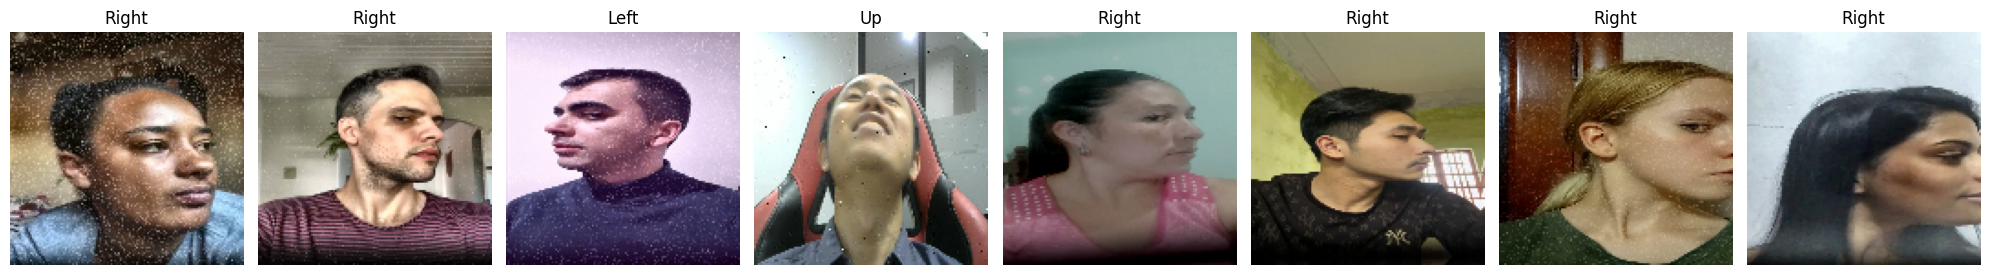

In [73]:
fig, ax = plt.subplots(ncols=8, figsize=(20, 20))

# Class label mapping (assuming classes: 0="Up", 1="Down", 2="Right", 3="Left")
class_labels = {0: "Up", 1: "Down", 2: "Right", 3: "Left"}

for idx in range(8):
    # Extract image and label
    sample_image = res[0][idx].copy()  # Extract the image (res[0] is the batch of images)
    sample_label = res[1][idx]  # Extract the classification label (res[1] is the batch of labels)

    # Normalize the image for `imshow` (ensure range [0, 255] for uint8)
    if sample_image.dtype != np.uint8:
        sample_image = np.clip(sample_image, 0, 1) * 255
        sample_image = sample_image.astype(np.uint8)

    # Print the label in the console
    print(f"Image {idx+1}: Label = {class_labels[int(sample_label)]}")

    # Display the image and add label as the title
    ax[idx].imshow(sample_image)
    ax[idx].set_title(class_labels[int(sample_label)], fontsize=12, color="black")
    ax[idx].axis('off')  # Hide axes

plt.tight_layout()
plt.show()


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf


### 8.2 Download Keras Model


In [18]:
mobilenet = MobileNetV2(include_top=False)

C:\Users\rafly\AppData\Local\Temp\ipykernel_16520\3428040069.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False)


In [24]:
mobilenet.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, None,      │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### 8.3 Build instance of Network

In [19]:
from tensorflow.keras.layers import BatchNormalization, Input, GlobalMaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [20]:
def build_model():
    input_layer = Input(shape=(128, 128, 3))
    input_layer = preprocess_input(input_layer)

    mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer, input_shape=(128, 128, 3))

    # Optionally freeze the MobileNetV2 layers
    for layer in mobilenet.layers[:-40]:
        layer.trainable = False

    # Classification Model
    f1 = GlobalAveragePooling2D()(mobilenet.output)  # Use GlobalAveragePooling
    class1 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(f1)  
    class1 = BatchNormalization()(class1)
    class1 = Dropout(0.5)(class1)  
    class_output = Dense(4, activation='softmax')(class1)

    # Create the classification-only model
    livenessdetector = Model(inputs=input_layer, outputs=class_output)
    return livenessdetector


### 8.4 Test out Neural Network

In [21]:
livenessdetector = build_model()

In [40]:
livenessdetector.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_156CL… │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ keras_tensor_156… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[1][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[1][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[1][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[1… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[1][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,917,956 (11.13 MB)

 Trainable params: 2,340,484 (8.93 MB)

 Non-trainable params: 577,472 (2.20 MB)

In [86]:
X, y = train.as_numpy_iterator().next()

In [87]:
X.shape

(8, 128, 128, 3)

In [88]:
classes = livenessdetector.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


In [89]:
classes

array([[0.45108366, 0.19093673, 0.17700565, 0.18097399],
       [0.5642928 , 0.2926147 , 0.0773695 , 0.06572311],
       [0.39341146, 0.13178003, 0.42424542, 0.05056308],
       [0.5485204 , 0.33313754, 0.05718784, 0.06115421],
       [0.21124409, 0.7554701 , 0.02636099, 0.00692482],
       [0.6770523 , 0.15932485, 0.13125305, 0.03236968],
       [0.28832814, 0.49000815, 0.16853176, 0.05313193],
       [0.50087935, 0.34470013, 0.09620759, 0.05821293]], dtype=float32)

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [22]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### 9.2 Create Localization Loss and Classification Loss

In [24]:
classloss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

### 9.3 Test out Loss Metrics

In [25]:
classloss

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [26]:
class LivenessDetector(Model):
    def __init__(self, livenessdetector, **kwargs):
        super().__init__(**kwargs)
        self.model = livenessdetector

    def compile(self, opt, classloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.opt = opt
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
        self.val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="val_accuracy")

    def train_step(self, batch):
        X, y = batch
        with tf.GradientTape() as tape:
            # Only classification output
            classes = self.model(X, training=True)

            # Compute classification loss
            batch_classloss = self.closs(y, classes)
            total_loss = batch_classloss

        grad = tape.gradient(total_loss, self.model.trainable_variables)
        grad = [tf.clip_by_norm(g, 1.0) for g in grad]  # Using gradient clipping by norm
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        # Update classification accuracy
        self.train_accuracy.update_state(y, classes)

        return {
            "total_loss": total_loss,
            "class_loss": batch_classloss,
            "accuracy": self.train_accuracy.result(),
        }

    def test_step(self, batch):
        X, y = batch
        # Only classification output
        classes = self.model(X, training=False)

        # Compute classification loss
        batch_classloss = self.closs(y, classes)
        total_loss = batch_classloss

        # Update validation accuracy
        self.val_accuracy.update_state(y, classes)

        return {
            "total_loss": total_loss,
            "class_loss": batch_classloss,
            "accuracy": self.val_accuracy.result(),
        }

    def call(self, inputs):
        return self.model(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            'livenessdetector_config': self.model.get_config()  # Store the model configuration
        })
        return config

    @classmethod
    def from_config(cls, config):
        livenessdetector_config = config['livenessdetector_config']
        livenessdetector_model = MobileNetV2.from_config(livenessdetector_config)  # Load the inner model
        return cls(livenessdetector_model)


In [27]:
model = LivenessDetector(livenessdetector)

In [28]:
model.compile(
    opt,
    classloss
)

### 10.2 Train

In [29]:
logdir='logs'

In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="class_loss",  # Metric to monitor
    patience=10,            # Number of epochs to wait before stopping
    mode="min",            # Specify that the metric should be minimized
    restore_best_weights=True  # Optionally restore the best weights
)


In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None and accuracy >= self.threshold:
            print(f"\nStopping training")
            self.model.stop_training = True

# Use the custom callback
accuracy_callback = AccuracyThresholdCallback(threshold=0.99)  # Stop at 99 accuracy)

In [33]:
hist = model.fit(
    train,
    epochs=30,
    validation_data=val,
    # callbacks=[early_stopping, accuracy_callback]
)

Epoch 1/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 68s 79ms/step - accuracy: 0.6881 - class_loss: 0.4729 - total_loss: 0.4729 - val_total_loss: 0.0140 - val_class_loss: 0.0140 - val_accuracy: 0.9226
Epoch 2/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 79s 105ms/step - accuracy: 0.9756 - class_loss: 0.0858 - total_loss: 0.0858 - val_total_loss: 0.6725 - val_class_loss: 0.6725 - val_accuracy: 0.9685
Epoch 3/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 83s 111ms/step - accuracy: 0.9894 - class_loss: 0.0326 - total_loss: 0.0326 - val_total_loss: 5.0663e-06 - val_class_loss: 5.0663e-06 - val_accuracy: 0.9842
Epoch 4/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 85s 115ms/step - accuracy: 0.9870 - class_loss: 0.0408 - total_loss: 0.0408 - val_total_loss: 1.0133e-06 - val_class_loss: 1.0133e-06 - val_accuracy: 0.9973
Epoch 5/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 86s 115ms/step - accuracy: 0.9960 - class_loss: 0.0202 - total_loss: 0.0202 - val_total_loss: 6.3144e-04 - val_class_loss: 6.3144e-04 - val_accuracy: 0.9836
Epoch 6/30
715/715 ━━━━━━━━━━━━━

### 10.3 Plot Performance

In [34]:
hist.history

{'total_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0027807930018752813>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0014713156269863248>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.002472279127687216>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.7311252779327333e-05>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0008090088958851993>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.005201732739806175>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.00017458683578297496>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.003389074932783842>,
  <tf.Tensor: shape=(), dtype=float32, numpy=5.4773252486484125e-05>,
  <tf.Tensor: shape=(), dtype=float32, numpy=7.210490002762526e-05>,
  <tf.Tensor: shape=(), dtype=float32, numpy=3.218630354240304e-06>,
  <tf.Tensor: shape=(), dtype=float32, numpy=4.1154544305754825e-05>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.4377057343372144e-05>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.00029603653820231557>,
  <tf.Tensor: sha

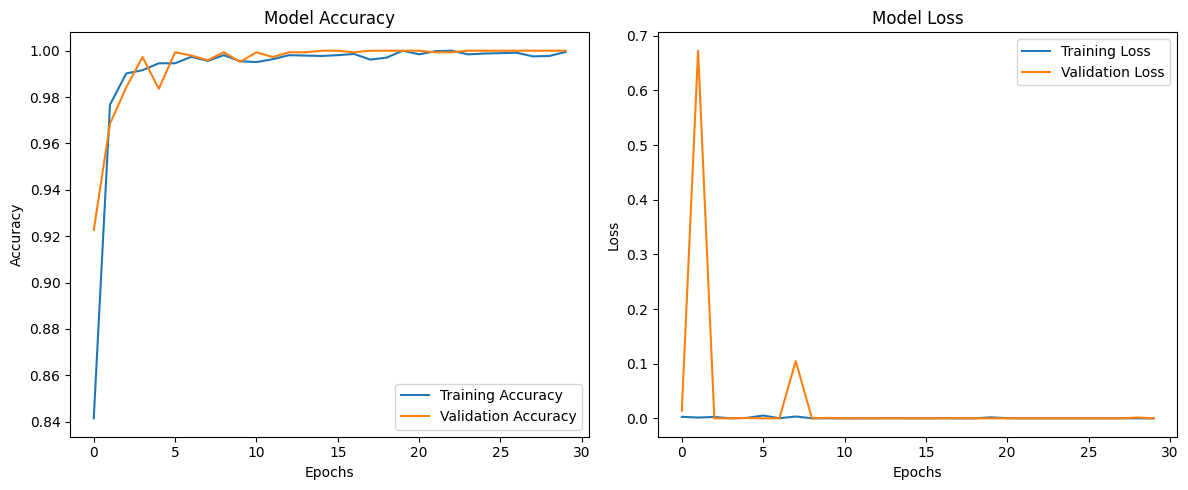

In [35]:
import matplotlib.pyplot as plt

# Extract the history data
history = hist.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Total Loss
plt.subplot(1, 2, 2)
plt.plot(history['total_loss'], label='Training Loss')
plt.plot(history['val_total_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [36]:
test_data = test.as_numpy_iterator()

In [37]:
test_sample = test_data.next()
yhat = model.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


Sample 0: Right (1.00)
Sample 1: Left (1.00)
Sample 2: Down (1.00)
Sample 3: Down (1.00)
Sample 4: Down (1.00)
Sample 5: Right (1.00)
Sample 6: Right (1.00)
Sample 7: Right (1.00)


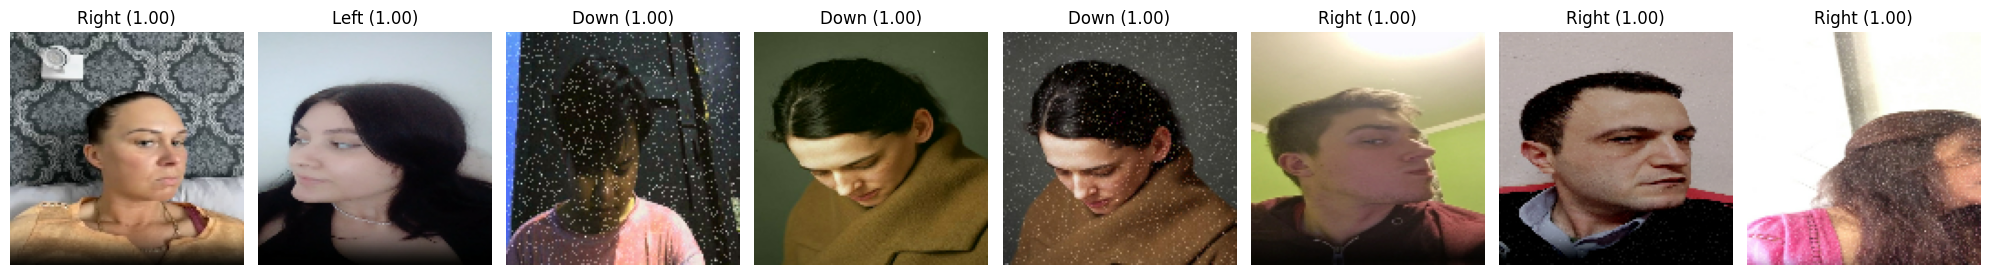

In [38]:
fig, ax = plt.subplots(ncols=8, figsize=(20, 20))
labels = []

# Confidence threshold
confidence_threshold = 0.3  # Updated to match the first snippet

# Class labels and colors for visualization
class_labels = {0: "Up", 1: "Down", 2: "Right", 3: "Left"}

for idx in range(8):
    # Make a writable copy of the image
    sample_image = test_sample[0][idx].copy()  # `test_sample[0]` contains the batch of images

    # Get maximum probability (confidence) and predicted class
    confidence = np.max(yhat[idx])  # Maximum probability for each sample
    predicted_class = np.argmax(yhat[idx])  # Class with the highest probability

    # Generate label text based on confidence threshold
    if confidence > confidence_threshold:
        label_text = f"{class_labels[predicted_class]} ({confidence:.2f})"
    else:
        label_text = f"No detection (confidence {confidence:.2f})"

    # Append the label for display in the console
    labels.append(label_text)

    # Normalize the image for display if necessary
    if sample_image.dtype != np.uint8:
        sample_image = np.clip(sample_image, 0, 1) * 255
        sample_image = sample_image.astype(np.uint8)

    # Plot the image and set the title
    ax[idx].imshow(sample_image)
    ax[idx].set_title(label_text, fontsize=12, color="black")
    ax[idx].axis("off")  # Hide axes

# Display the predictions in the console
for i, lbl in enumerate(labels):
    print(f"Sample {i}: {lbl}")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Sample 0: Left (0.86)
Sample 1: Up (1.00)
Sample 2: Down (0.99)
Sample 3: Right (1.00)
Sample 4: Up (0.89)
Sample 5: Right (0.85)
Sample 6: Up (0.93)
Sample 7: Down (0.51)


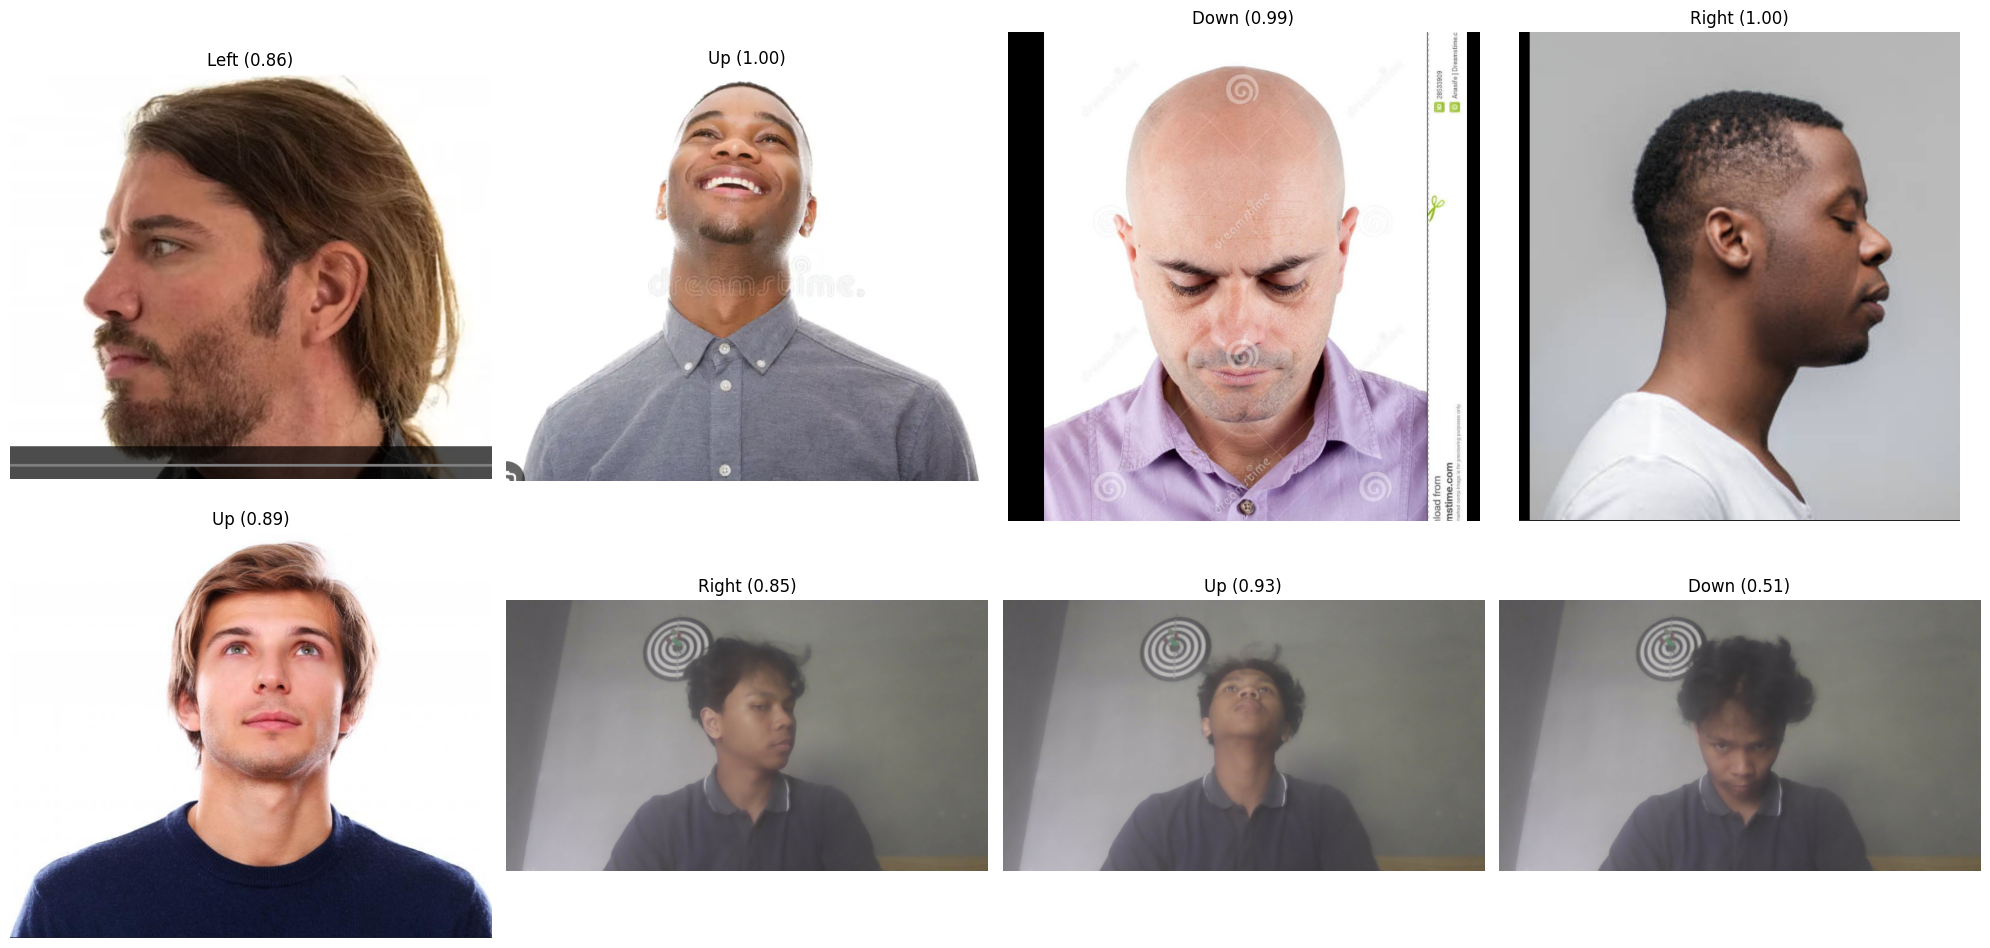

In [43]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Folder where the images are located
# folder_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/new faces'
folder_path = "D:/UNS/Kuliah/Semester 5/Bangkit/LivenessDetectionmMobilenet_CLASSONLY/dataset/new faces"

# Model input dimensions
image_size = (224, 224)  # Adjust to your model's input size if different

# Load images from the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]

# Number of images
num_images = len(image_files)

# Dynamically set the layout of subplots based on the number of images
ncols = 4
nrows = int(np.ceil(num_images / ncols))  # Calculate the number of rows needed

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 5))  # Adjust figure height based on rows
labels = []

# Confidence threshold
confidence_threshold = 0.3  # Adjust if necessary

# Class labels for visualization
class_labels = {0: "Up", 1: "Down", 2: "Right", 3: "Left"}

for idx, image_file in enumerate(image_files):  # No limit, process all images
    image_path = os.path.join(folder_path, image_file)

    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    img_resized = img.resize(image_size)  # Resize to match model input size
    img_array = np.array(img_resized) / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make predictions
    yhat = model.predict(img_array)

    # Get maximum probability (confidence) and predicted class
    confidence = np.max(yhat[0])  # Maximum probability for the current image
    predicted_class = np.argmax(yhat[0])  # Class with the highest probability

    # Generate label text based on confidence threshold
    if confidence > confidence_threshold:
        label_text = f"{class_labels[predicted_class]} ({confidence:.2f})"
    else:
        label_text = f"No detection (confidence {confidence:.2f})"

    # Append the label for display in the console
    labels.append(label_text)

    # Plot the image and set the title
    row = idx // ncols
    col = idx % ncols
    ax[row, col].imshow(img)
    ax[row, col].set_title(label_text, fontsize=12, color="black")
    ax[row, col].axis("off")  # Hide axes

# Remove any unused subplots if the number of images is not a perfect multiple of ncols
for remaining in range(idx + 1, nrows * ncols):
    fig.delaxes(ax.flatten()[remaining])

# Display the predictions in the console
for i, lbl in enumerate(labels):
    print(f"Sample {i}: {lbl}")

plt.tight_layout()
plt.show()


In [60]:
# del model

### 11.2 Save the Model

In [41]:
import tensorflow as tf

# Assuming `livenessdetector` is your trained model
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('LivenessDetectionFinal.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\rafly\AppData\Local\Temp\tmp3twupkum\assets


INFO:tensorflow:Assets written to: C:\Users\rafly\AppData\Local\Temp\tmp3twupkum\assets


Saved artifact at 'C:\Users\rafly\AppData\Local\Temp\tmp3twupkum'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2159701493712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701498512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701498704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701498320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701497744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701499088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701500432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701500624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701500240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701499472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701501008: 

In [42]:
import tensorflow as tf

# Assuming `livenessdetector` is your trained model
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model
with open('LivenessDetectionFinalOptimized.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\rafly\AppData\Local\Temp\tmpmvpvcyib\assets


INFO:tensorflow:Assets written to: C:\Users\rafly\AppData\Local\Temp\tmpmvpvcyib\assets


Saved artifact at 'C:\Users\rafly\AppData\Local\Temp\tmpmvpvcyib'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2159701493712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701498512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701498704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701498320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701497744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701499088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701500432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701500624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701500240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701499472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159701501008: 